# Data analysis and price prediction: Airbnb listings in Berlin
### Dataset
Is accessible as 'Airbnb Berlin.csv', retrieved from kaggle.
### Objective
Build a predictive model: Predict price based on features of a listing such as location, size etc. Prediction shall be understood as a helping tool for new listings to estimate appropriate price. Therefore, reviews and ratings of listings are in this step irrelevant.

In [126]:
# import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = [10, 10]

## 1. First data exploration and cleaning

In the first steps the data set is simplified by:
* Dropping duplicates in Listing ID (as duplicates should contain same information per listing)
* Selecting only features (columns) relevant for price prediction

In [127]:
# read csv and print info
df = pd.read_csv('Airbnb_Berlin.csv', dtype={'Postal Code': 'str', 'Price': 'str'})
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456961 entries, 0 to 456960
Data columns (total 47 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   index                  456961 non-null  int64  
 1   Review ID              452805 non-null  float64
 2   review_date            452805 non-null  object 
 3   Reviewer ID            452805 non-null  float64
 4   Reviewer Name          452805 non-null  object 
 5   Comments               452597 non-null  object 
 6   Listing ID             456961 non-null  int64  
 7   Listing URL            456961 non-null  object 
 8   Listing Name           456756 non-null  object 
 9   Host ID                456961 non-null  int64  
 10  Host URL               456961 non-null  object 
 11  Host Name              456913 non-null  object 
 12  Host Since             456913 non-null  object 
 13  Host Response Time     398194 non-null  object 
 14  Host Response Rate     398194 non-nu

In [128]:
# print head
print(df.head())

   index   Review ID review_date  Reviewer ID Reviewer Name  \
0      0  58660447.0    01-03-16   14876562.0        Dennis   
1      1         NaN         NaN          NaN           NaN   
2      2  58663795.0    01-03-16   49367757.0       Andreea   
3      3  59003619.0    01-05-16   46694292.0         Sasha   
4      4  66845661.0    03-25-16   54542819.0        Yohana   

                                            Comments  Listing ID  \
0  Very nice, clean appartement! Josh was really ...    10002699   
1                                                NaN    10002922   
2  Aki is really nice and friendly. We had an ama...    10006647   
3  Aki is a very nice dude with a clean place in ...    10006647   
4  Aki's place was easy to find and located in th...    10006647   

                             Listing URL                     Listing Name  \
0  https://www.airbnb.com/rooms/10002699  Trendy and peaceful KreuzkÃ¶lln   
1  https://www.airbnb.com/rooms/10002922  Sehr zentrale Wo

In [129]:
# print number of unique values in listing ID
print(df['Listing ID'].nunique())

23536


In [130]:
# drop duplicates in Listing ID
df = df.drop_duplicates(subset='Listing ID')

# drop columns concerning reviews 
col_reviews_ratings = ['Review ID', 'review_date', 'Reviewer ID', 'Reviewer Name', 'Comments', 'Overall Rating', 'Reviews', 
                       'First Review', 'Last Review', 'Accuracy Rating', 'Cleanliness Rating', 'Checkin Rating', 
                       'Communication Rating', 'Location Rating', 'Value Rating']
df = df.drop(labels=col_reviews_ratings, axis=1)

# again print info
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23536 entries, 0 to 456958
Data columns (total 32 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   index                  23536 non-null  int64  
 1   Listing ID             23536 non-null  int64  
 2   Listing URL            23536 non-null  object 
 3   Listing Name           23482 non-null  object 
 4   Host ID                23536 non-null  int64  
 5   Host URL               23536 non-null  object 
 6   Host Name              23515 non-null  object 
 7   Host Since             23515 non-null  object 
 8   Host Response Time     13046 non-null  object 
 9   Host Response Rate     13046 non-null  object 
 10  Is Superhost           23515 non-null  object 
 11  neighbourhood          23536 non-null  object 
 12  Neighborhood Group     23536 non-null  object 
 13  City                   23533 non-null  object 
 14  Postal Code            22951 non-null  object 
 15  C

Furthermore, we drop:
* columns that contain other irrelevant aspects such as URLs, IDs (except Listing ID for now), names, host related info (except Is Superhost).
* column wih very low non-null count: Square Feet

In [131]:
# drop descriptive columns  
col_irr = ['Listing URL', 'Listing Name', 'Host ID', 'Host URL', 'Host Name', 'Host Since', 'Host Response Time', 
           'Host Response Rate', 'Square Feet']
df = df.drop(labels=col_irr, axis=1)

# again print info
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23536 entries, 0 to 456958
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   index                  23536 non-null  int64  
 1   Listing ID             23536 non-null  int64  
 2   Is Superhost           23515 non-null  object 
 3   neighbourhood          23536 non-null  object 
 4   Neighborhood Group     23536 non-null  object 
 5   City                   23533 non-null  object 
 6   Postal Code            22951 non-null  object 
 7   Country Code           23536 non-null  object 
 8   Country                23536 non-null  object 
 9   Latitude               23536 non-null  float64
 10  Longitude              23536 non-null  float64
 11  Is Exact Location      23536 non-null  object 
 12  Property Type          23536 non-null  object 
 13  Room Type              23536 non-null  object 
 14  Accomodates            23536 non-null  int64  
 15  B

Then, we explore the columns/features we are not sure about yet. Based on the value counts we get, we:
* Drop the columns neighbourhood, Neighborhood Group, City, Country Code, Country as we assume that the location is sufficiently described in Latitude + Longitude and that all rental units are located in (Greater) Berlin (to be confirmed exploring Latitude + Longitude). 
* Change values of the columns Is Superhost, Instant Bookable from 'f'/'t' to Boolean False/True.
* Drop column Business Travel Ready, as all values are 'f'.
* Drop rows with null values.
* After having identified all unique listings we don't need the Listing ID and index anymore and drop them.
* Change target variable to float


In [132]:
feat_in_quest = ['Is Superhost', 'neighbourhood', 'Neighborhood Group', 'City', 'Postal Code', 'Country Code', 'Country',
                 'Is Exact Location', 'Property Type', 'Room Type', 'Instant Bookable', 'Business Travel Ready']
for feat in feat_in_quest:
    print('\n' + 'value counts in feature {}:'.format(feat) + '\n')
    print(df[feat].value_counts())



value counts in feature Is Superhost:

f    19948
t     3567
Name: Is Superhost, dtype: int64

value counts in feature neighbourhood:

NeukÃ¶lln                    3444
Prenzlauer Berg              2995
Kreuzberg                    2936
Friedrichshain               2782
Mitte                        2212
                             ... 
KonradshÃ¶he                    4
Falkenberg                      3
Blankenfelde                    1
Stadtrandsiedlung Malchow       1
Wartenberg                      1
Name: neighbourhood, Length: 93, dtype: int64

value counts in feature Neighborhood Group:

Friedrichshain-Kreuzberg    5726
Mitte                       4865
Pankow                      3687
NeukÃ¶lln                   3587
Charlottenburg-Wilm.        1676
Tempelhof - SchÃ¶neberg     1586
Lichtenberg                  743
Treptow - KÃ¶penick          626
Steglitz - Zehlendorf        468
Reinickendorf                296
Marzahn - Hellersdorf        147
Spandau                      129
Na

In [133]:
# drop superfluous location related columns  
col_loc = ['neighbourhood', 'Neighborhood Group', 'City', 'Postal Code', 'Country Code', 'Country']
df = df.drop(labels=col_loc, axis=1)

# drop Listing ID
df = df.drop(labels='Listing ID', axis=1)

# drop Business Travel Ready column  
df = df.drop(labels='Business Travel Ready', axis=1)

# replace 'f'/'t' by False/True
df = df.replace({'f': False, 't':True})

In [134]:
# convert Price to float
df['Price'] = df['Price'].str.replace(',','')
df['Price'] = df['Price'].astype(float)

In [135]:
# drop rows with null values
df = df.dropna()

In [136]:
# drop and reset index column
df = df.drop(labels='index', axis=1)
list_index = [i for i in range(23439)]
df.index = list_index 

In [137]:
# metrics of numerical features and target variable
print(df.describe())

           Latitude     Longitude   Accomodates     Bathrooms      Bedrooms  \
count  23439.000000  23439.000000  23439.000000  23439.000000  23439.000000   
mean      52.509917     13.406188      2.673536      1.096165      1.162038   
std        0.031284      0.058493      1.569750      0.346545      0.661517   
min       52.346200     13.097180      1.000000      0.000000      0.000000   
25%       52.489160     13.375765      2.000000      1.000000      1.000000   
50%       52.509260     13.416560      2.000000      1.000000      1.000000   
75%       52.532700     13.439465      3.000000      1.000000      1.000000   
max       52.651670     13.757640     16.000000      8.500000     10.000000   

               Beds         Price  Guests Included    Min Nights  
count  23439.000000  23439.000000     23439.000000  23439.000000  
mean       1.642348     69.200734         1.346090      6.862323  
std        1.229852    209.042209         0.857162     24.057935  
min        0.000000 

In [138]:
# count rental units with price 0
print(df[df['Price']==0].shape)

(6, 14)


In [139]:
# drop rows with price 0
df=df.drop(df[df['Price']==0].index)

In [140]:
# again print info
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23433 entries, 0 to 23438
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Is Superhost       23433 non-null  object 
 1   Latitude           23433 non-null  float64
 2   Longitude          23433 non-null  float64
 3   Is Exact Location  23433 non-null  bool   
 4   Property Type      23433 non-null  object 
 5   Room Type          23433 non-null  object 
 6   Accomodates        23433 non-null  int64  
 7   Bathrooms          23433 non-null  float64
 8   Bedrooms           23433 non-null  float64
 9   Beds               23433 non-null  float64
 10  Price              23433 non-null  float64
 11  Guests Included    23433 non-null  int64  
 12  Min Nights         23433 non-null  int64  
 13  Instant Bookable   23433 non-null  bool   
dtypes: bool(2), float64(6), int64(3), object(3)
memory usage: 2.4+ MB
None


We end up having 23433 rows and 14 columns (+ index) consisting of 13 features and the target variable:
* Is Superhost: Boolean, whether host is superhost
* Latitude: float, latitude on map of rental unit
* Longitude: float, longitude on map of rental unit
* Is Exact Location: Boolean, whether exact location is shown in the ad
* Property Type: Categorical string, labelling type of the property
* Room Type: Categorical string, labelling type of the room
* Accomodates:  integer
* Bathrooms: float, number of bathrooms in rental unit
* Bedrooms: float, number of bedrooms in rental unit
* Beds: float, number of beds in rental unit
* Price: float, price per night of rental unit (TARGET!)
* Guests Included: integer
* Min Nights: minimum number of nights to be booked
* Instant Bookable: Boolean, whether instant booking option is available

### 2. More detailed EDA and visualization
#### 2.1 Target variable
Findings:
* The distribution of the target variable price is left skewed. This is to be expected as it has a fixed (and excluded) lower limit 0, but no upper limit. To get rid of this skewness we apply the np.log on the price and store it in a separate column.

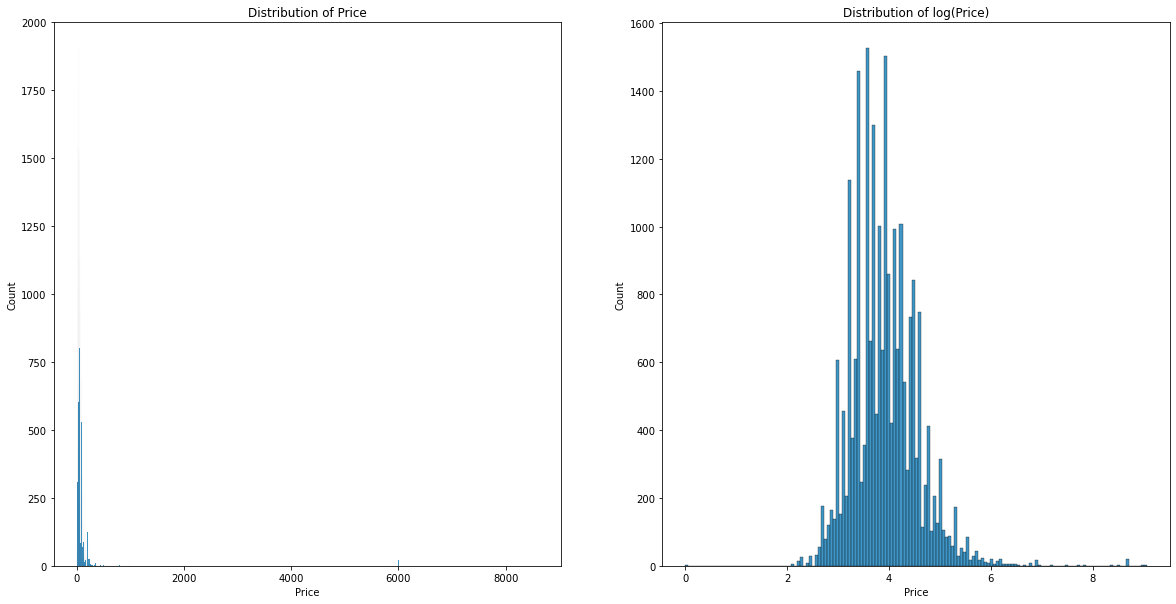

In [141]:
fig, axes=plt.subplots(1,2, figsize=(20,10))
sns.histplot(df['Price'],ax=axes[0]).set(title='Distribution of Price')
sns.histplot(np.log(df['Price']),ax=axes[1]).set(title='Distribution of log(Price)')
plt.show()

In [142]:
df['Price_log']=np.log(df['Price'])

#### 2.2 Numeric features
Findings:
* Plotting longitude vs. latitude yields roughly the shape of Greater Berlin, this is a good sanity check for the two feature variables. Marking the data points with labels (one of four price ranges) doesn't really show as explicit clusters of a certain price range in a specific area.
* The heatmap with the pearson correlation coefficients between all variables suggest: There seems to be a stronger linear correlation between some of the feature variables and the potential target variable log(price) then between the same feature variables and the price (without the log).
* Exemplary, comparing the scatterplots Price vs. Accomodates/Price vs. Beds with log(Price) vs. Accomodates/log(Price) vs. Beds also suggests a stronger linear correlation between some feature variables and log(price).

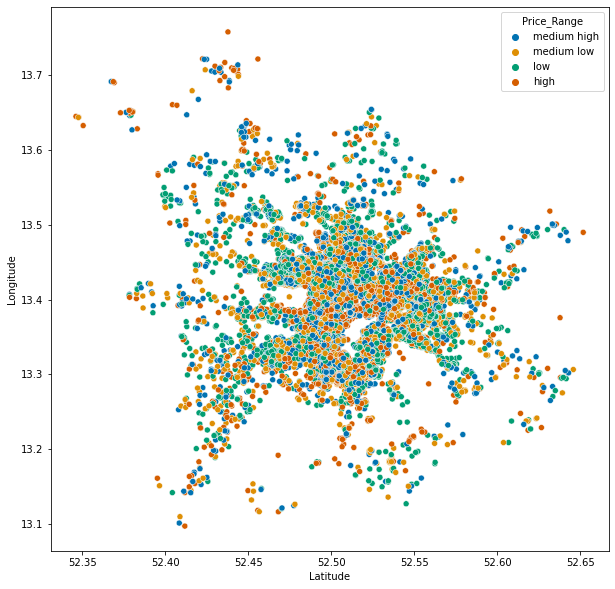

In [143]:
# set seaborn palette
sns.set_palette('colorblind')

# categorize listings in 4 different price ranges 
df_price_ranges = df.copy()
list_conds = [df_price_ranges['Price'] > 75.0,
              (75.0 >= df_price_ranges['Price']) & (df_price_ranges['Price'] > 49.0),
              (49.0 >= df_price_ranges['Price']) & (df_price_ranges['Price'] > 32.0),
              32.0 >= df_price_ranges['Price']]
list_price_ranges = ['high', 'medium high', 'medium low', 'low']
df_price_ranges['Price_Range'] = np.select(list_conds, list_price_ranges)

# scatterplot longitude vs. latitude
sns.scatterplot(x='Latitude', y='Longitude', data=df_price_ranges, hue='Price_Range')
plt.show()

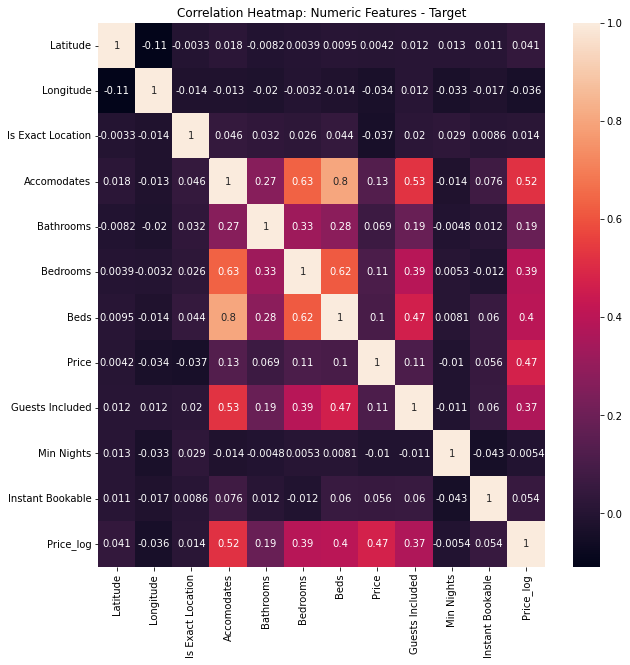

In [144]:
sns.heatmap(df.corr(), annot=True).set(title='Correlation Heatmap: Numeric Features - Target')
plt.show()

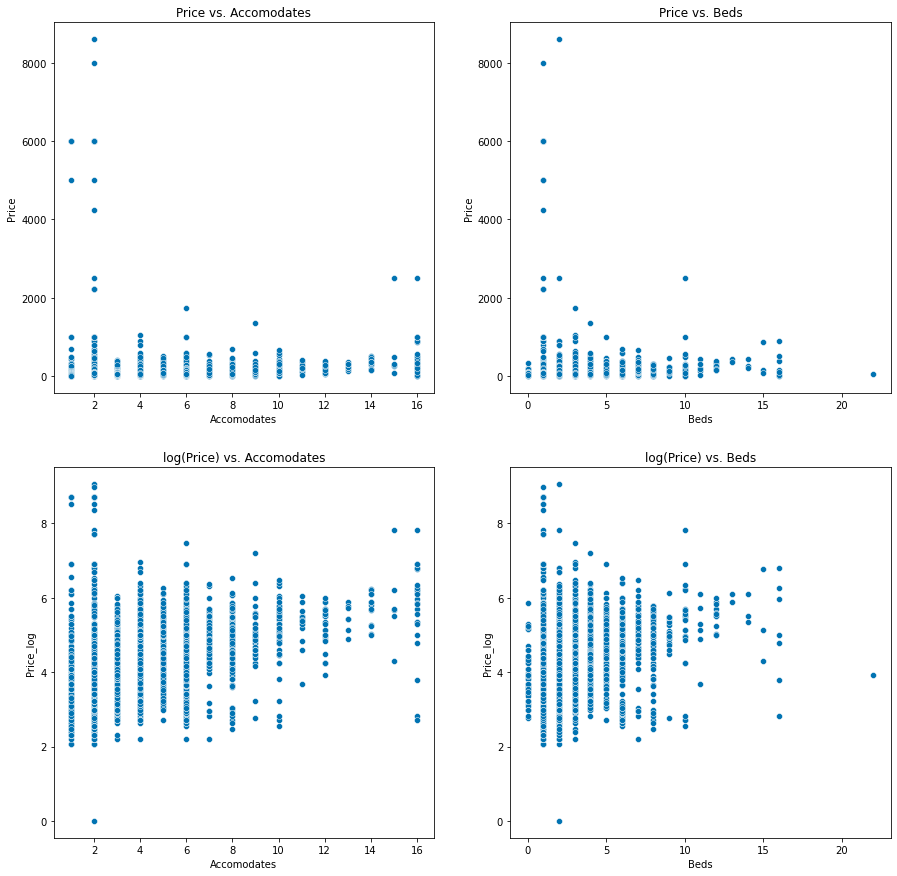

In [145]:
fig, axes = plt.subplots(2,2,figsize=(15,15))
sns.scatterplot(data=df, x='Accomodates', y='Price', ax=axes[0,0]).set(title='Price vs. Accomodates')
sns.scatterplot(data=df, x='Beds', y='Price', ax=axes[0,1]).set(title='Price vs. Beds')
sns.scatterplot(data=df, x='Accomodates', y='Price_log', ax=axes[1,0]).set(title='log(Price) vs. Accomodates')
sns.scatterplot(data=df, x='Beds', y='Price_log', ax=axes[1,1]).set(title='log(Price) vs. Beds')
plt.show()

#### 2.3 Categorical features
Findings:
* 
* 

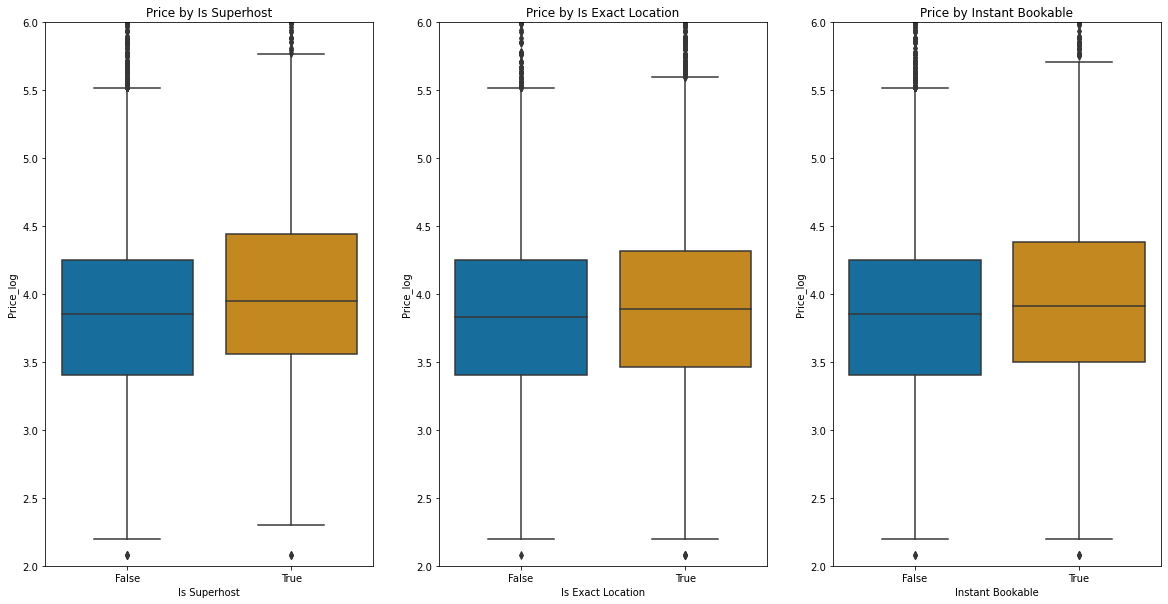

In [146]:
# boxplots price by the Boolean variables (Is Superhost, Is Exact Location, Instant Bookable)
fig, axes = plt.subplots(1,3, figsize=(20,10))
sns.boxplot(data=df, x='Is Superhost', y='Price_log', ax=axes[0]).set(title='Price by Is Superhost')
sns.boxplot(data=df, x='Is Exact Location', y='Price_log', ax=axes[1]).set(title='Price by Is Exact Location')
sns.boxplot(data=df, x='Instant Bookable', y='Price_log', ax=axes[2]).set(title='Price by Instant Bookable')
ax1, ax2, ax3 = axes
ax1.set_ylim([2, 6])
ax2.set_ylim([2, 6])
ax3.set_ylim([2, 6])
plt.show()

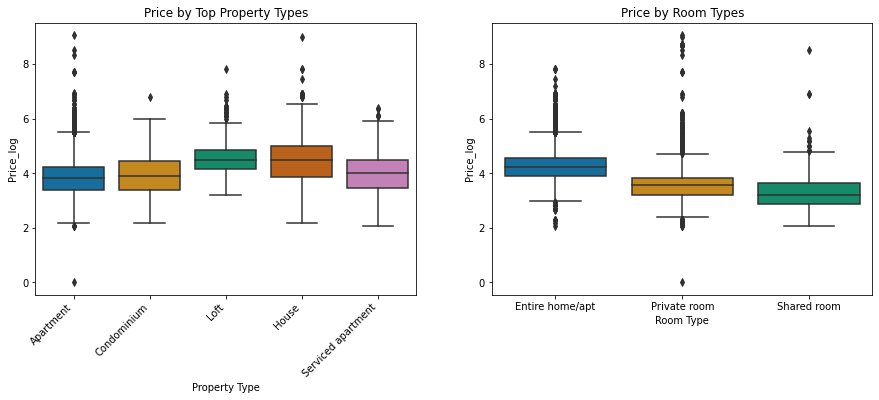

In [147]:
# get top 5 property types
prop_val_counts = df['Property Type'].value_counts()
prop_top_5 = list(prop_val_counts[:5].index)

fig, axes = plt.subplots(1,2, figsize=(15,5))
sns.boxplot(data=df[df['Property Type'].isin(prop_top_5)], x='Property Type', y='Price_log', ax=axes[0]).set(title='Price by Top Property Types')
sns.boxplot(data=df, x='Room Type', y='Price_log', ax=axes[1]).set(title='Price by Room Types')
ax1,ax2=axes
ax1.set_xticklabels(prop_top_5, rotation=45, ha='right')
plt.show()

In [148]:
# show medians of top 5 property types
df_prop_top_5 = df[df['Property Type'].isin(prop_top_5)]
print(df_prop_top_5.groupby('Property Type')[['Price', 'Price_log']].median())

                    Price  Price_log
Property Type                       
Apartment            46.0   3.828641
Condominium          55.0   4.007333
House                50.0   3.912023
Loft                 89.0   4.488636
Serviced apartment   89.0   4.488636


In [149]:
# show medians of room types
print(df.groupby('Room Type')[['Price', 'Price_log']].median())

                 Price  Price_log
Room Type                        
Entire home/apt   69.0   4.234107
Private room      35.0   3.555348
Shared room       25.0   3.218876


### 3. Modelling
Predicting the price is a regression problem. As straightforward and easily interpretable models Regression and Decision Tree is chosen. For comparing the two models, they are evaluated with the R-squared and RMSE (Root Mean Squared Error).

To prepare the data for modelling, the following steps are taken:
* 
* 
* 


In [150]:
# imports for modelling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import r2_score, mean_squared_error 

In [151]:
# one hot encoding of categorical variables
le = LabelEncoder()
df['Property Type'] = le.fit_transform(df['Property Type'])
df['Room Type'] = le.fit_transform(df['Room Type'])

In [152]:
# standardize numeric variables
ss = StandardScaler()
num_var = ['Latitude', 'Longitude', 'Accomodates', 'Bathrooms', 'Bedrooms', 'Beds', 'Guests Included', 'Min Nights']
df[num_var] = ss.fit_transform(df[num_var])

In [158]:
# create train and test sets
X = df.drop(['Price', 'Price_log'], axis=1)
y = df['Price_log']                     # could be changed to df['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

#### 3.1 Linear Regression

In [159]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [160]:
# predict on test set
y_pred = lr.predict(X_test)
# print metrics
print('Linear regression r2 score: ', r2_score(y_test, y_pred))
print('Linear regression RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred)))

Linear regression r2 score:  0.4306930500674411
Linear regression RMSE:  0.48168163842692807
